In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from progressbar import ProgressBar
from sklearn.preprocessing import MinMaxScaler
import scipy

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Reshape, Flatten, GlobalMaxPooling1D, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.initializers import glorot_normal
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse

plt.rcParams.update({'font.size': 18})

2022-12-12 12:28:22.677777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 12:28:23.651141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-12 12:28:23.651248: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-12 12:28:23.651257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

## Load the Capacity data
- Three datasets: Train, Test1, Test2, Test3

In [2]:
number_cells = [41,42,40,45] # train and three tests
dataset = ['train', 'test1', 'test2', 'test3']

all_Q_curves = pd.DataFrame()
for myset in range(len(dataset)):
    for cell in range(number_cells[myset]):
        cell_Q = pd.read_csv("Dataset/discharge_capacity/"+dataset[myset]+"/cell"+str(cell+1)+".csv", 
                               header = None, names=['cycle_no', 'capacity', 'initial_capacity'])
        cell_Q['cell_no'] = cell+1 # cell number
        cell_Q['norm_Q'] = cell_Q['capacity']/cell_Q['initial_capacity'].iloc[0] # cell number
        cell_Q['dataset'] = dataset[myset]
        all_Q_curves = pd.concat([all_Q_curves, cell_Q], axis=0)

## Plot the capacity curves

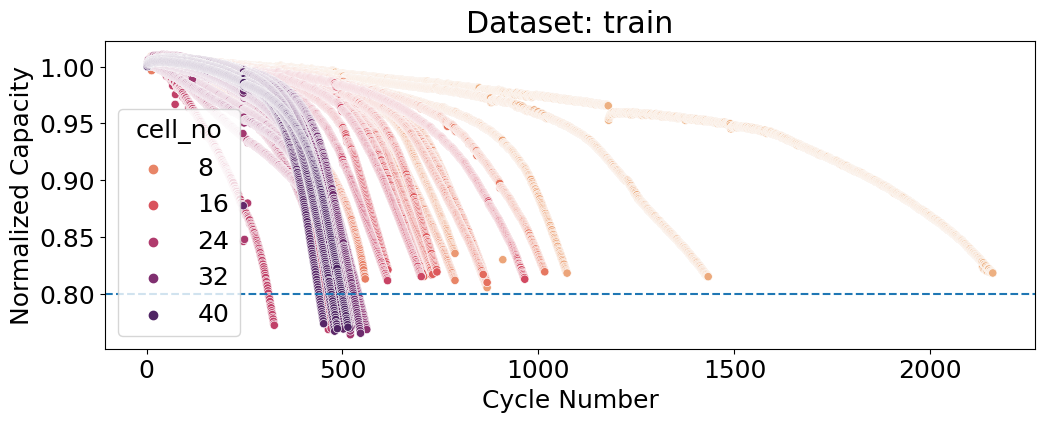

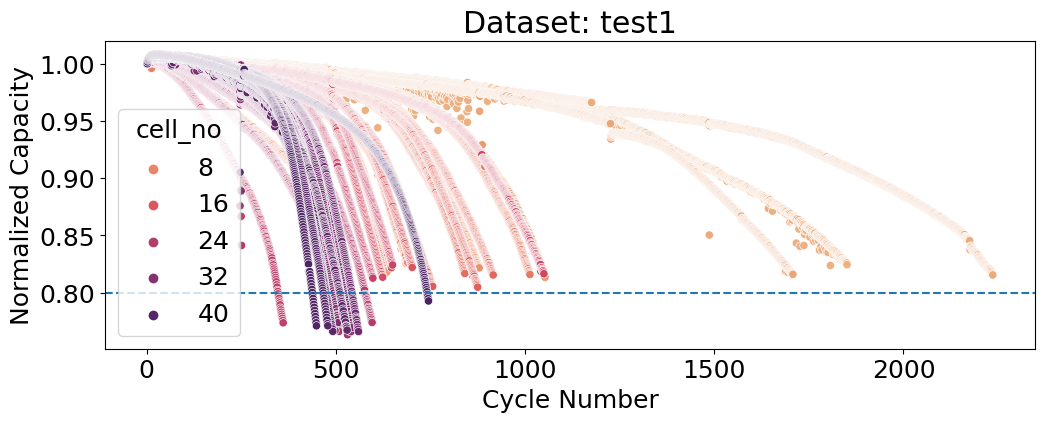

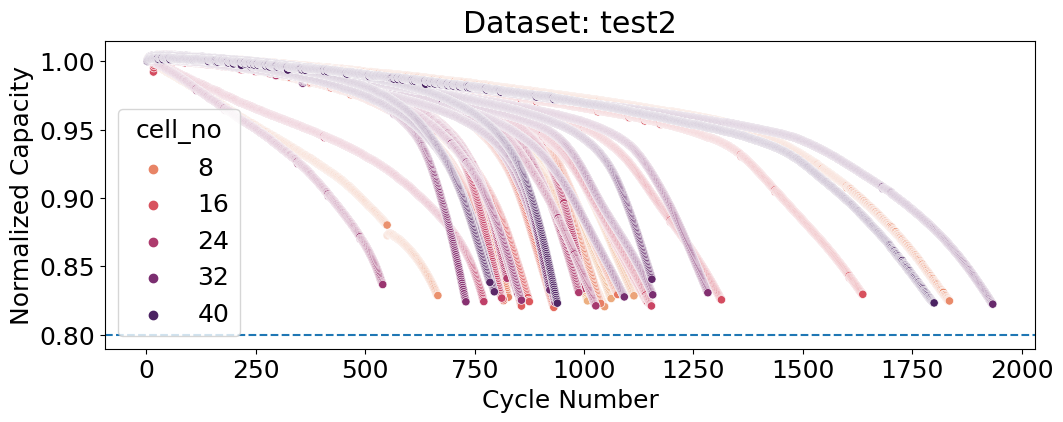

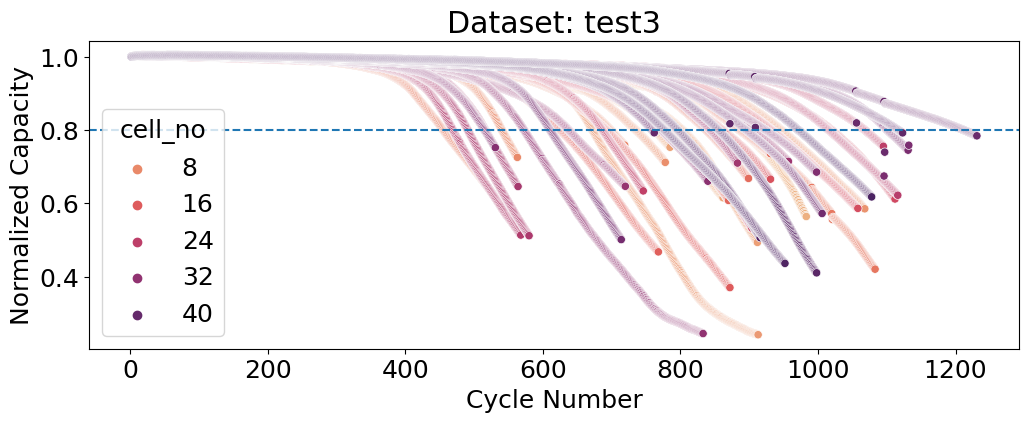

In [3]:
for myset in range(len(dataset)):
    fig = plt.figure(figsize=(12,4))
    sns.scatterplot(
        data=all_Q_curves.loc[all_Q_curves['dataset']==dataset[myset]], 
        x="cycle_no", y="norm_Q", hue="cell_no", palette="flare"
    )
    plt.axhline(0.8, linestyle='dashed')
    plt.title("Dataset: "+ dataset[myset])
    plt.xlabel("Cycle Number")
    plt.ylabel("Normalized Capacity")

## Load the VQ curve data

### We will use VQ(cycle=100)-VQ(cycle=10) as feature to determine RUL

In [4]:
VQcol_names = ["cycle_"+str(i+1) for i in range(150)]
all_VQ_curves = pd.DataFrame()
for myset in range(len(dataset)):
    for cell in range(number_cells[myset]):
        cell_VQ = pd.read_csv("Dataset/V_Q_curve/"+dataset[myset]+"/cell"+str(cell+1)+".csv", header = None,
                               names=VQcol_names)
        cell_VQ['voltage'] = np.linspace(3.5,2,cell_VQ.shape[0])
        cell_VQ['diff_cycle100_cycle10'] = cell_VQ['cycle_100']-cell_VQ['cycle_10']
        cell_VQ['cell_no'] = cell+1 # cell number
        cell_VQ['dataset'] = dataset[myset]
        all_VQ_curves = pd.concat([all_VQ_curves, cell_VQ], axis=0)

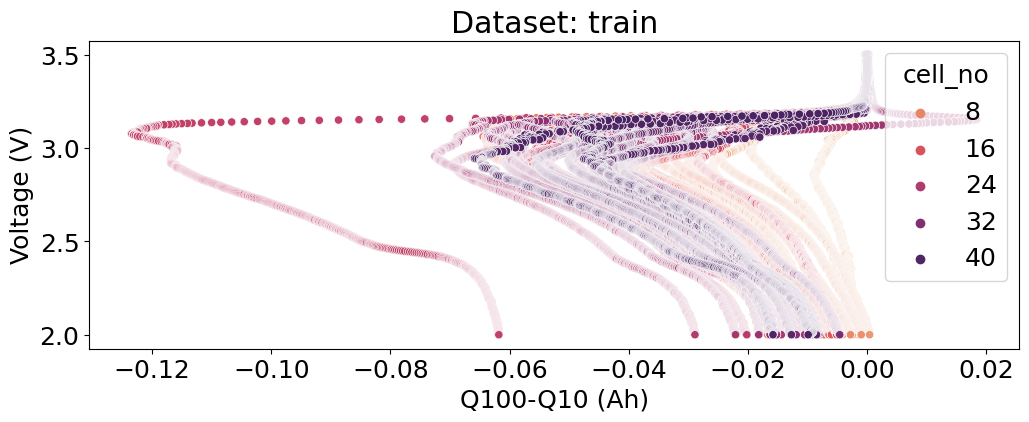

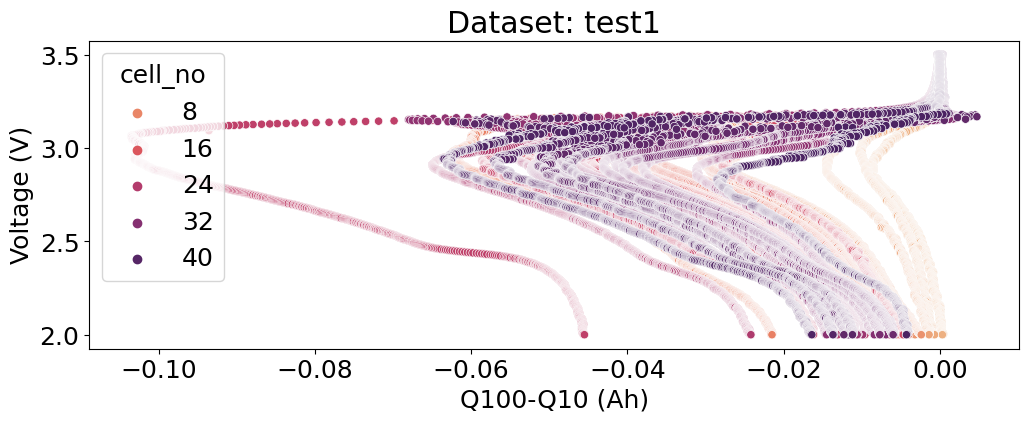

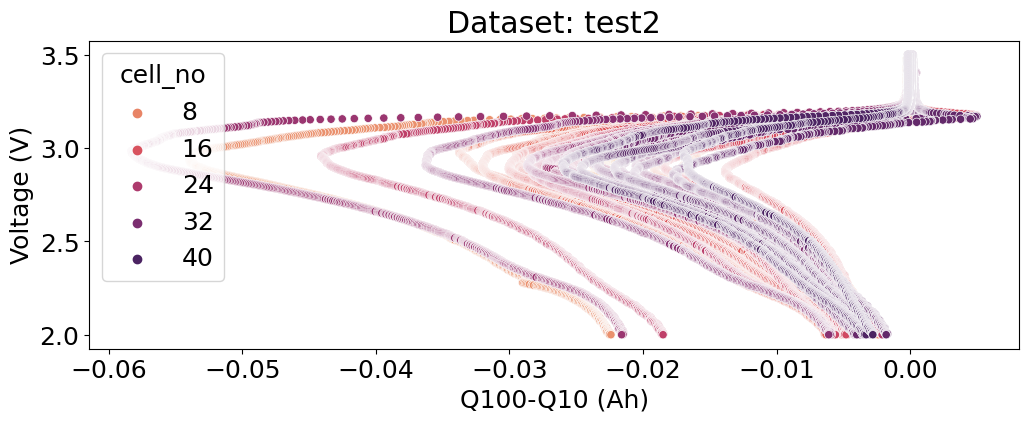

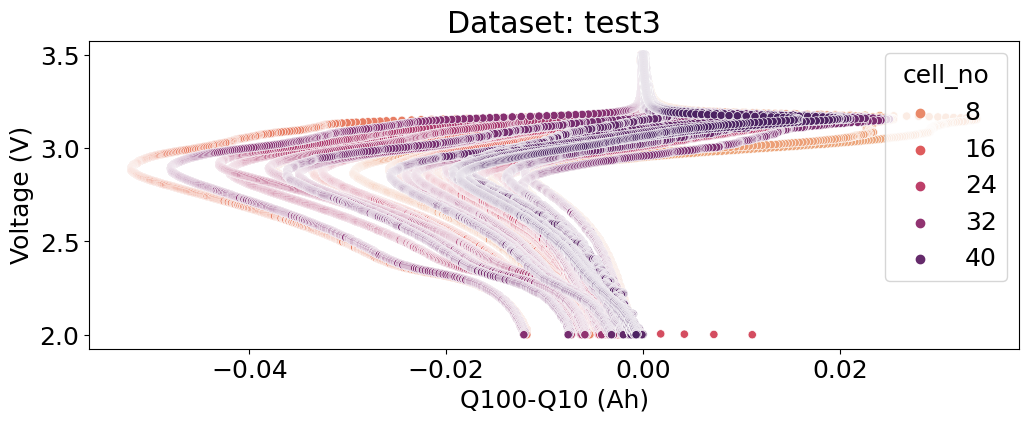

In [5]:
for myset in range(len(dataset)):
    fig = plt.figure(figsize=(12,4))
    sns.scatterplot(
        data=all_VQ_curves.loc[all_VQ_curves['dataset']==dataset[myset]], 
        x="diff_cycle100_cycle10", y="voltage", hue="cell_no", palette="flare"
    )
    plt.title("Dataset: "+ dataset[myset])
    plt.xlabel("Q100-Q10 (Ah)")
    plt.ylabel("Voltage (V)")

In [6]:
all_VQ_curves.head()

,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,cycle_9,cycle_10,...,cycle_145,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10,cell_no,dataset
0,-0.000460,-0.000352,-0.000451,-0.000230,-0.000168,-0.000447,-0.000328,-0.000361,-0.000158,-0.000167,...,-0.000295,-0.000340,-0.000292,-0.000329,-0.000307,NaN,3.500000,-0.000097,1,train
1,-0.000418,-0.000314,-0.000404,-0.000201,-0.000141,-0.000400,-0.000290,-0.000320,-0.000132,-0.000141,...,-0.000259,-0.000306,-0.000262,-0.000293,-0.000273,NaN,3.498498,-0.000092,1,train
2,-0.000378,-0.000278,-0.000360,-0.000172,-0.000114,-0.000356,-0.000254,-0.000282,-0.000106,-0.000115,...,-0.000225,-0.000272,-0.000232,-0.000259,-0.000240,NaN,3.496997,-0.000087,1,train
3,-0.000340,-0.000243,-0.000319,-0.000144,-0.000089,-0.000314,-0.000220,-0.000246,-0.000082,-0.000090,...,-0.000193,-0.000240,-0.000203,-0.000227,-0.000208,NaN,3.495495,-0.000082,1,train
4,-0.000303,-0.000211,-0.000281,-0.000116,-0.000064,-0.000275,-0.000188,-0.000212,-0.000059,-0.000066,...,-0.000163,-0.000209,-0.000174,-0.000196,-0.000178,NaN,3.493994,-0.000078,1,train


In [7]:
all_VQ_curves.groupby(by=['dataset', 'cell_no']).var().reset_index()

,dataset,cell_no,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,...,cycle_143,cycle_144,cycle_145,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10
0,test1,1,0.178752,0.179241,0.179079,0.179453,0.179358,0.179632,0.179590,0.179506,...,0.177868,0.177846,0.177759,0.177704,0.177670,0.177508,0.177683,NaN,0.188063,0.000009
1,test1,2,0.181725,0.182183,0.181989,0.182463,0.182225,0.182640,0.182494,0.182277,...,0.180655,0.180659,0.180621,0.180616,0.180548,0.180525,0.180546,NaN,0.188063,0.000011
2,test1,3,0.182167,0.182007,0.181987,0.182112,0.182336,0.182235,0.182355,0.182331,...,0.179545,0.179510,0.179463,0.179449,0.179423,0.179420,0.179379,NaN,0.188063,0.000025
3,test1,4,0.182607,0.182857,0.183438,0.183404,0.183316,0.183366,0.183376,0.183458,...,0.176391,0.176259,0.176179,0.176167,0.176036,0.176073,0.175996,NaN,0.188063,0.000169
4,test1,5,0.182917,0.183044,0.183438,0.183402,0.183329,0.183819,0.183975,0.183916,...,0.178252,0.178320,0.178365,0.178328,0.178260,0.178228,0.178179,NaN,0.188063,0.000105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,train,37,0.182196,0.182502,0.182961,0.182664,0.182682,0.183001,0.182762,0.182846,...,0.170665,0.170499,0.170139,0.170217,0.170072,0.169928,0.169949,NaN,0.188063,0.000308
164,train,38,0.183576,0.183577,0.184326,0.184238,0.184364,0.184615,0.184484,0.184521,...,0.170353,0.170470,0.170269,0.169122,0.170035,0.169658,0.169626,NaN,0.188063,0.000353
165,train,39,0.179789,0.179786,0.179393,0.180324,0.180193,0.179621,0.180416,0.180068,...,0.168280,0.168657,0.167971,0.167886,0.168248,0.167921,0.168274,NaN,0.188063,0.000207
166,train,40,0.182214,0.182752,0.182559,0.182490,0.182954,0.183030,0.183081,0.183180,...,0.167826,0.167731,0.167097,0.167074,0.167128,0.166798,0.166745,NaN,0.188063,0.000476


In [8]:
all_cycle_lives = pd.DataFrame()
for myset in range(len(dataset)):
    cycle_lives = pd.read_csv("Dataset/cycle_lives/"+dataset[myset]+"_cycle_lives.csv", header = None,
                             names=['cycle_life']).reset_index()
    cycle_lives['cell_no'] = cycle_lives['index'] + 1
    cycle_lives['dataset'] = dataset[myset]
    
    all_cycle_lives = pd.concat([all_cycle_lives, cycle_lives.drop('index', axis=1)], axis=0)

In [9]:
all_cycle_lives.head()

,cycle_life,cell_no,dataset
0,2160,1,train
1,1434,2,train
2,1074,3,train
3,870,4,train
4,788,5,train


In [10]:
all_VQ_curves_merge = pd.merge(all_VQ_curves, all_cycle_lives, how='left',
                               left_on = ['dataset', 'cell_no'], right_on = ['dataset', 'cell_no'])
all_VQ_curves_merge_agg = all_VQ_curves_merge.groupby(by=['cell_no', 'dataset']).agg({'diff_cycle100_cycle10':'var',
                                                            'cycle_life': 'mean'}).reset_index()

## Data Visualization
(similar to the Nature Energy paper)

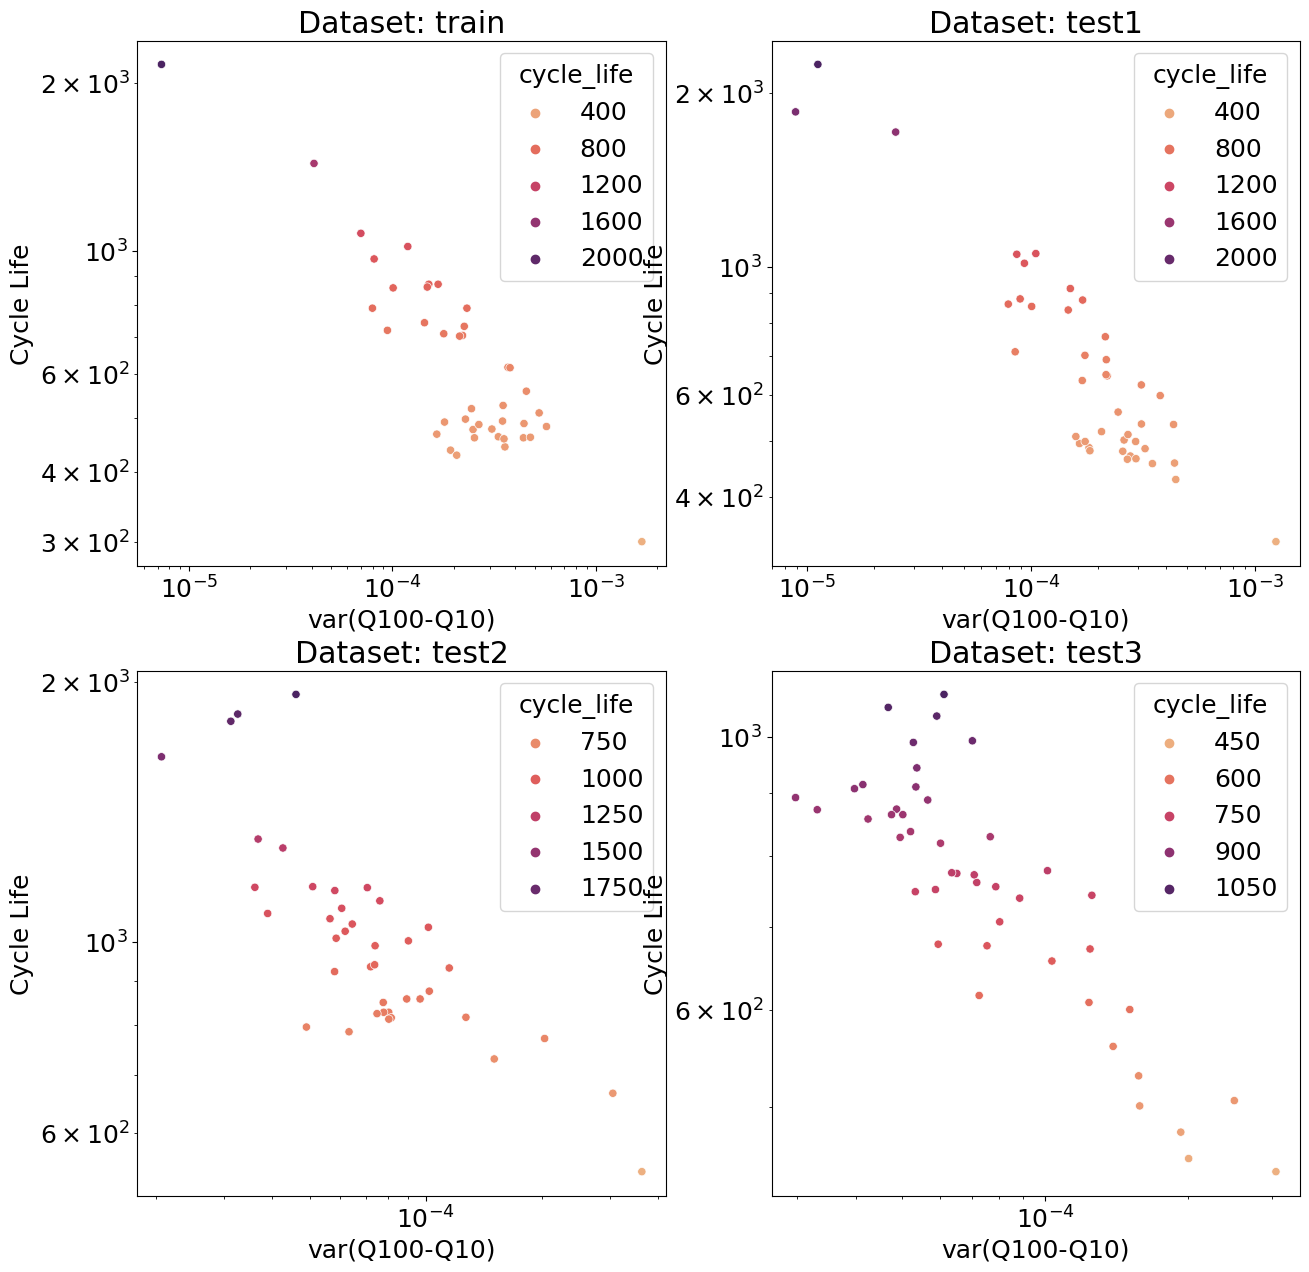

In [11]:
fig, ax = plt.subplots(2,2,figsize=(15, 15))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    sns.scatterplot(
        data=all_VQ_curves_merge_agg.loc[all_VQ_curves_merge_agg['dataset']==dataset[myset]], 
        x="diff_cycle100_cycle10", y="cycle_life", hue="cycle_life", palette="flare", ax = myax
    )
    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("var(Q100-Q10)")
    myax.set_ylabel("Cycle Life")
    myax.set_xscale('log')
    myax.set_yscale('log')

In [12]:
all_VQ_curves_merge.head()

,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,cycle_9,cycle_10,...,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10,cell_no,dataset,cycle_life
0,-0.000460,-0.000352,-0.000451,-0.000230,-0.000168,-0.000447,-0.000328,-0.000361,-0.000158,-0.000167,...,-0.000340,-0.000292,-0.000329,-0.000307,NaN,3.500000,-0.000097,1,train,2160
1,-0.000418,-0.000314,-0.000404,-0.000201,-0.000141,-0.000400,-0.000290,-0.000320,-0.000132,-0.000141,...,-0.000306,-0.000262,-0.000293,-0.000273,NaN,3.498498,-0.000092,1,train,2160
2,-0.000378,-0.000278,-0.000360,-0.000172,-0.000114,-0.000356,-0.000254,-0.000282,-0.000106,-0.000115,...,-0.000272,-0.000232,-0.000259,-0.000240,NaN,3.496997,-0.000087,1,train,2160
3,-0.000340,-0.000243,-0.000319,-0.000144,-0.000089,-0.000314,-0.000220,-0.000246,-0.000082,-0.000090,...,-0.000240,-0.000203,-0.000227,-0.000208,NaN,3.495495,-0.000082,1,train,2160
4,-0.000303,-0.000211,-0.000281,-0.000116,-0.000064,-0.000275,-0.000188,-0.000212,-0.000059,-0.000066,...,-0.000209,-0.000174,-0.000196,-0.000178,NaN,3.493994,-0.000078,1,train,2160


## Make Input-Output for training the UQ models
Input:- VQ(100)-VQ(10)

Output:- cycle life

In [13]:
def get_input_output(df, myset):
    df_myset = df.loc[df['dataset']==myset]
    X, Y = [], []
    for mycell in sorted(set(df_myset['cell_no'])):
        X.append(df_myset.loc[df_myset['cell_no']==mycell].sort_values(
            by='voltage', ascending = False, axis = 0)['diff_cycle100_cycle10'].values)
        Y.append(df_myset.loc[df_myset['cell_no']==mycell]['cycle_life'].mean())
    return X, np.expand_dims(Y, axis=1)

In [14]:
Xtrain, Ytrain = get_input_output(all_VQ_curves_merge, 'train')
Xtest1, Ytest1 = get_input_output(all_VQ_curves_merge, 'test1')
Xtest2, Ytest2 = get_input_output(all_VQ_curves_merge, 'test2')
Xtest3, Ytest3 = get_input_output(all_VQ_curves_merge, 'test3')

scalerX = MinMaxScaler()
Xtrain_norm, Ytrain_norm  = scalerX.fit_transform(Xtrain), (Ytrain)/np.max(Ytrain)
Xtest1_norm, Ytest1_norm  = scalerX.transform(Xtest1), (Ytest1)/np.max(Ytrain)
Xtest2_norm, Ytest2_norm  = scalerX.transform(Xtest2), (Ytest2)/np.max(Ytrain)
Xtest3_norm, Ytest3_norm  = scalerX.transform(Xtest3), (Ytest3)/np.max(Ytrain)

## Uncertainty Model 1: Deep Ensemble (DE)

- Use of Gaussian Layer that outputs - mean and aleatoric variance
- Use of Negative Log Likelihood loss
- Ensemble to capture epistematic uncertainty

In [15]:
# loss function and new custom layer to give mean and standard deviation
def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.math.log((sigma)) + 0.5*tf.math.divide(tf.math.square(y_true - y_pred), (sigma))) + 1e-6
    return gaussian_loss
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [16]:
def generate_trained_DEmodel(trainX, trainY, nepochs, actfn = 'sigmoid'):
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    x = Dense(10, activation = actfn)(x)
      
    mu, sigma = GaussianLayer(1, name='main_output')(x)
    model = Model(feature_input, mu)
    model.compile(loss=custom_loss(sigma), optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)
    
    layer_name = 'main_output' # Where to extract the Gaussian output from. 
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)
    return get_intermediate

In [26]:
## Create 20 models and select some based on training error
prediction_fns, train_mae = [], []
nmodels = 10
nepochs = 300

pbar=ProgressBar()
for i in pbar(range(nmodels)):
    my_func = generate_trained_DEmodel(Xtrain_norm, Ytrain_norm, nepochs, actfn = 'tanh')
    train_mae.append(mae(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
    prediction_fns.append(my_func)
    
nmodels_select = 5
final_DE_fns = []
for i in range(nmodels_select):
    final_DE_fns.append(prediction_fns[np.argsort(train_mae)[:nmodels_select][i]])

2022-12-12 11:23:23.542845: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-12-12 11:23:23.581497: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-12-12 11:23:23.581543: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-12 11:23:23.582718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI

In [27]:
def get_ensemble(df, UQmodelcode, nmodels_select):
    mu_cols = [UQmodelcode + "_mu_"+str(i) for i in range(nmodels_select)]
    sigma_cols = [UQmodelcode + "_sigma_"+str(i) for i in range(nmodels_select)]
    
    mu_eff = df[mu_cols].mean(axis=1)
    if UQmodelcode=="DE":
        sigma_eff =  np.sqrt(np.mean(df[mu_cols]**2, axis = 1)
                             + np.mean(df[sigma_cols]**2, axis = 1)
                             - mu_eff**2)
    elif UQmodelcode=="MC":
        sigma_eff =  np.sqrt(np.mean(df[mu_cols]**2, axis = 1)
                             - mu_eff**2)
    df[UQmodelcode+"_mu_eff"] = mu_eff
    df[UQmodelcode+"_sigma_eff"] = sigma_eff
    return df

allresults_df = pd.DataFrame()
for myset in dataset:
    exec("Xnorm =X"+myset+"_norm")
    exec("Y =Y"+myset)

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    for i in range(nmodels_select):
        result_df["DE_mu_"+str(i)] = (final_DE_fns[i](Xnorm)[0])*np.max(Ytrain)
        result_df["DE_sigma_"+str(i)] = (np.sqrt(final_DE_fns[i](Xnorm)[1]))*np.max(Ytrain)

    result_df = get_ensemble(result_df, "DE", nmodels_select)
    allresults_df = pd.concat([allresults_df, result_df], axis = 0)
allresults_df.head()

,True,dataset,DE_mu_0,DE_sigma_0,DE_mu_1,DE_sigma_1,DE_mu_2,DE_sigma_2,DE_mu_3,DE_sigma_3,DE_mu_4,DE_sigma_4,DE_mu_eff,DE_sigma_eff
0,2160.0,train,1916.672363,178.180191,1884.218750,255.835266,1855.891968,279.345001,1918.524292,327.394501,1822.143921,173.955078,1879.490234,252.767181
1,1434.0,train,1311.675171,143.989349,1296.213745,222.196060,1529.238525,211.411087,1263.038696,318.697327,1305.513306,158.859528,1341.135864,239.683121
2,1074.0,train,960.038330,127.326027,994.227051,206.867020,1115.018311,154.837723,925.813660,314.273804,966.861328,149.119308,992.391785,212.206116
3,870.0,train,721.391296,117.215385,755.773987,195.790894,856.723328,126.991119,736.021057,311.959167,816.838989,144.855255,777.349731,199.833054
4,788.0,train,848.946960,122.865746,968.307129,206.130188,1052.573853,153.663239,961.541504,315.310150,918.088501,147.420715,949.891602,211.929672


## Results - Visualization

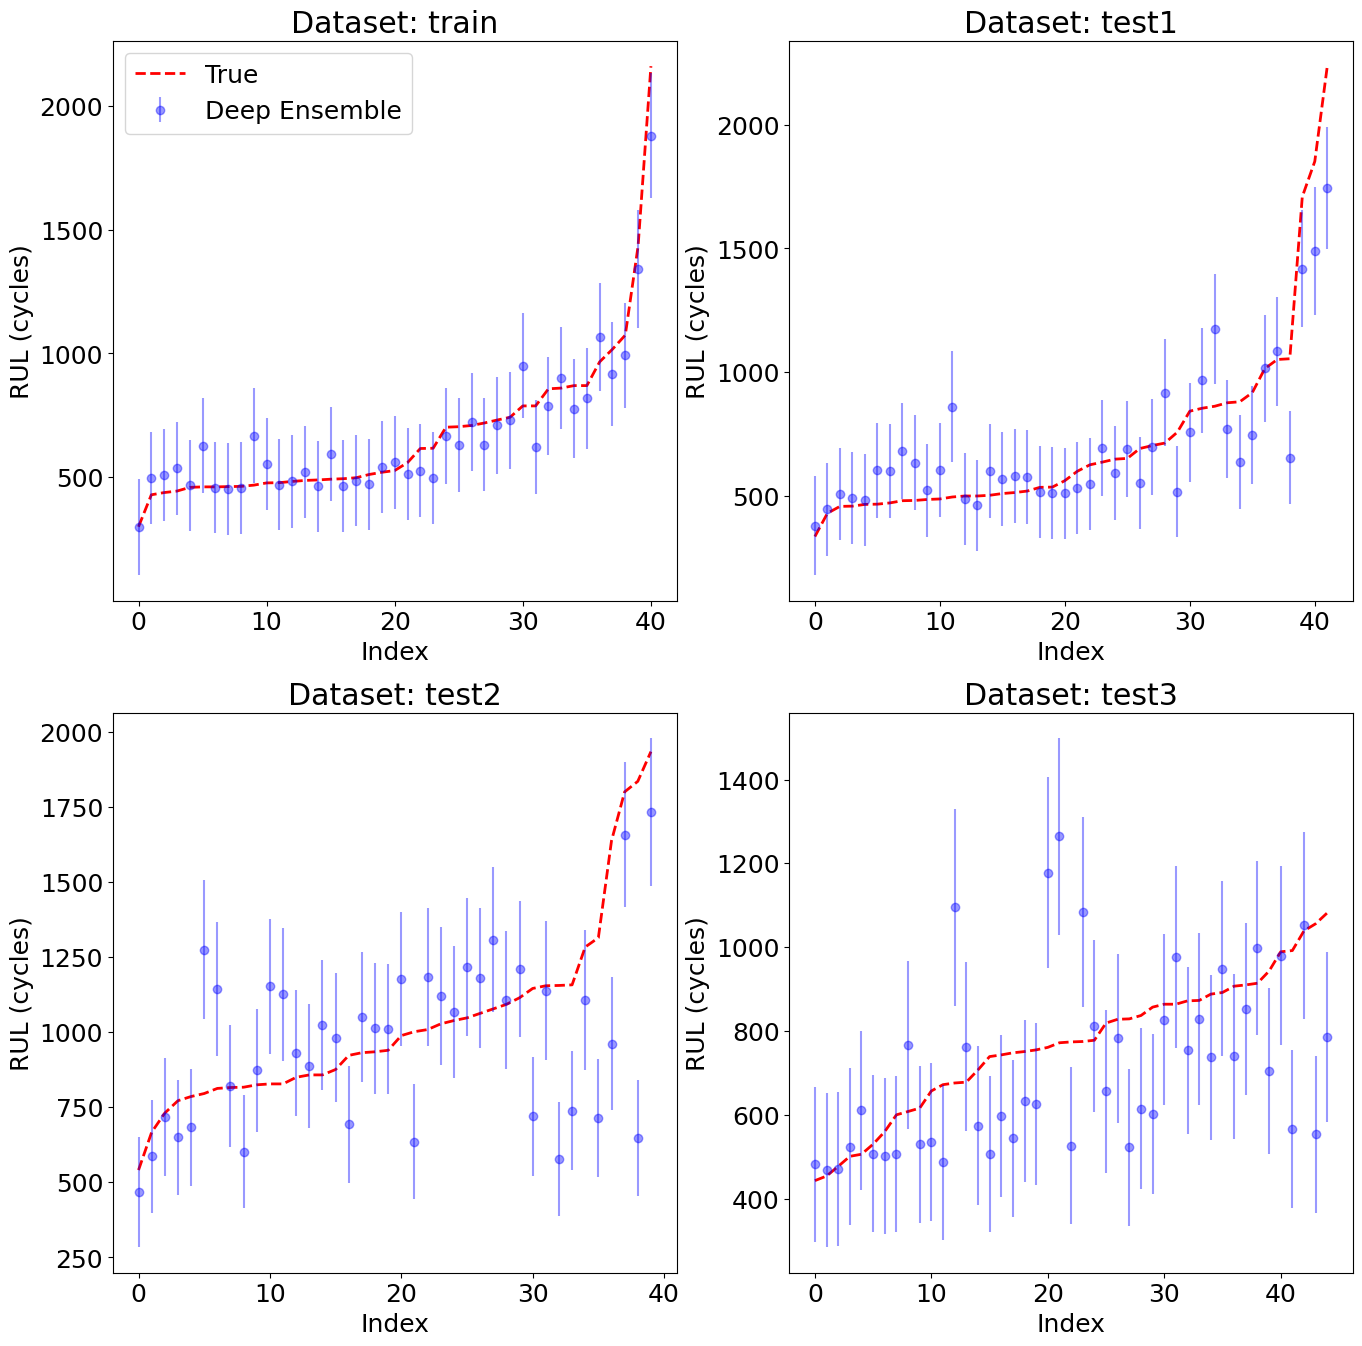

In [28]:
allresults_df_sorted = allresults_df.sort_values(by='True', ascending=True)
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    df = allresults_df_sorted.loc[allresults_df_sorted['dataset']==dataset[myset]]
    myax.plot(range(df.shape[0]), df['True'], 
             color='red', linestyle='dashed', linewidth=2, label='True')
    myax.errorbar(range(df.shape[0]), df['DE_mu_eff'], 
                 yerr = df['DE_sigma_eff'],
                 fmt='o', color='blue', alpha = 0.4, label='Deep Ensemble')
    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Index")
    myax.set_ylabel("RUL (cycles)")
    if myset ==0:
        myax.legend()

In [29]:
allresults_df_sorted.head()

,True,dataset,DE_mu_0,DE_sigma_0,DE_mu_1,DE_sigma_1,DE_mu_2,DE_sigma_2,DE_mu_3,DE_sigma_3,DE_mu_4,DE_sigma_4,DE_mu_eff,DE_sigma_eff
20,300.0,train,281.522003,106.233086,331.619446,193.657043,302.580200,179.388397,296.920990,297.741150,279.470306,132.564255,298.422607,194.400665
21,335.0,test1,451.709045,106.676712,438.707581,182.009430,249.745026,104.879845,444.248291,308.324066,313.813568,133.073624,379.644714,201.167801
38,429.0,train,484.175720,107.837868,528.034180,185.608612,506.543549,100.556236,507.473938,308.985809,458.633026,136.028046,496.972076,185.993195
40,429.0,test1,470.615417,107.364189,466.425323,183.089752,467.825623,98.234146,444.409485,308.620850,372.803436,134.584305,444.415863,187.032547
21,438.0,train,503.963226,108.601151,525.937317,185.538101,515.885254,101.017494,530.250122,309.339508,473.734924,136.452301,509.954163,185.894379


In [30]:
def get_confidence_interval(y_true, mu, sigma):
    alphas = np.linspace(1e-10, 1-1e-10, 1000)
    myCI=[]
    for myalpha in sorted(alphas):
        intervals = scipy.stats.norm.interval(alpha=myalpha, loc=mu, scale=sigma)
        lower_bd = intervals[0]
        upper_bd = intervals[1]
        myCI.append(np.sum((y_true > lower_bd) & (y_true < upper_bd))/len(y_true))
    
    return 100*alphas, 100*np.array(myCI)  # converting to percentages

In [31]:
alphas, CI_DE = get_confidence_interval(allresults_df_sorted['True'].values, 
                                       allresults_df_sorted['DE_mu_eff'].values, 
                                       allresults_df_sorted['DE_sigma_eff'].values)


/tmp/ipykernel_1688229/625823574.py:5: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  intervals = scipy.stats.norm.interval(alpha=myalpha, loc=mu, scale=sigma)


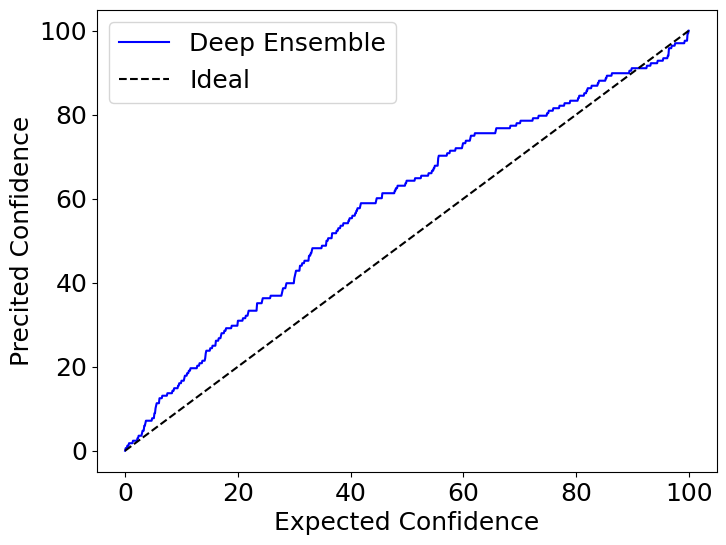

In [32]:
fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_DE, color = 'blue', label='Deep Ensemble')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

## Repeat the above algorithm for 10 times to capture variations

In [33]:
## Multiple runs
niter = 10
allCI_DE = np.zeros((1000, niter))
pbar=ProgressBar()

for myiter in pbar(range(niter)):
    prediction_fns=[]
    train_mae=[]
    for i in range(nmodels):
        my_func = generate_trained_DEmodel(Xtrain_norm, Ytrain_norm, nepochs, actfn = 'tanh')
        train_mae.append(mae(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
        prediction_fns.append(my_func)

    nmodels_select = 5
    final_DE_fns = []
    for i in range(nmodels_select):
        final_DE_fns.append(prediction_fns[np.argsort(train_mae)[:nmodels_select][i]])

    allresults_df = pd.DataFrame()
    for myset in dataset:
        exec("Xnorm =X"+myset+"_norm")
        exec("Y =Y"+myset)

        result_df = pd.DataFrame(Y, columns = ['True'])
        result_df['dataset'] = myset
        for i in range(nmodels_select):
            result_df["DE_mu_"+str(i)] = (final_DE_fns[i](Xnorm)[0])*np.max(Ytrain)
            result_df["DE_sigma_"+str(i)] = (np.sqrt(final_DE_fns[i](Xnorm)[1]))*np.max(Ytrain)

        result_df = get_ensemble(result_df, "DE", nmodels_select)
        allresults_df = pd.concat([allresults_df, result_df], axis = 0)
    allresults_df.head()

    allresults_df_sorted = allresults_df.sort_values(by='True', ascending=True)

    alphas, CI_DE = get_confidence_interval(allresults_df_sorted['True'].values, 
                                           allresults_df_sorted['DE_mu_eff'].values, 
                                           allresults_df_sorted['DE_sigma_eff'].values)
    allCI_DE[:,myiter] = CI_DE

2022-12-12 11:23:46.930213: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_10/kernel_2/Assign' id:4817 op device:{requested: '', assigned: ''} def:{{{node main_output_10/kernel_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](main_output_10/kernel_2, main_output_10/kernel_2/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:23:48.465260: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_10/add' id:4848 op device:{requested: '', assigned: ''} def:{{{node main_output_10/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](main_output_10/MatMul, main_output_10/add/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and wil

2022-12-12 11:24:04.960571: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_17/add' id:8166 op device:{requested: '', assigned: ''} def:{{{node main_output_17/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](main_output_17/MatMul, main_output_17/add/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:24:05.751418: W tensorflow/c/c_api.cc:291] Operation '{name:'training_36/Adam/iter/Assign' id:8824 op device:{requested: '', assigned: ''} def:{{{node training_36/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_36/Adam/iter, training_36/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the fut

2022-12-12 11:24:25.818236: W tensorflow/c/c_api.cc:291] Operation '{name:'training_50/Adam/beta_2/Assign' id:12152 op device:{requested: '', assigned: ''} def:{{{node training_50/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_50/Adam/beta_2, training_50/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:24:27.754356: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_25/add' id:11958 op device:{requested: '', assigned: ''} def:{{{node main_output_25/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](main_output_25/MatMul, main_output_25/add/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger a

2022-12-12 11:24:50.589070: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_32/add' id:15276 op device:{requested: '', assigned: ''} def:{{{node main_output_32/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](main_output_32/MatMul, main_output_32/add/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:24:51.813259: W tensorflow/c/c_api.cc:291] Operation '{name:'training_66/Adam/main_output_33/kernel_1/v/Assign' id:16027 op device:{requested: '', assigned: ''} def:{{{node training_66/Adam/main_output_33/kernel_1/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_66/Adam/main_output_33/kernel_1/v, training_66/Adam/main_output_33/kernel_1/v/Initializer/zeros)}}' was changed by setting attribute after it was run

/tmp/ipykernel_1688229/625823574.py:5: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  intervals = scipy.stats.norm.interval(alpha=myalpha, loc=mu, scale=sigma)
2022-12-12 11:25:17.821160: W tensorflow/c/c_api.cc:291] Operation '{name:'training_80/Adam/dense_81/bias/v/Assign' id:19340 op device:{requested: '', assigned: ''} def:{{{node training_80/Adam/dense_81/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_80/Adam/dense_81/bias/v, training_80/Adam/dense_81/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:25:20.196434: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_40/add' id:19068 op dev

2022-12-12 11:25:48.751580: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_47/add' id:22386 op device:{requested: '', assigned: ''} def:{{{node main_output_47/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](main_output_47/MatMul, main_output_47/add/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:25:50.383293: W tensorflow/c/c_api.cc:291] Operation '{name:'training_96/Adam/main_output_48/bias_1/v/Assign' id:23147 op device:{requested: '', assigned: ''} def:{{{node training_96/Adam/main_output_48/bias_1/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_96/Adam/main_output_48/bias_1/v, training_96/Adam/main_output_48/bias_1/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a se

2022-12-12 11:26:22.991595: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_55/kernel_2/Assign' id:26147 op device:{requested: '', assigned: ''} def:{{{node main_output_55/kernel_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](main_output_55/kernel_2, main_output_55/kernel_2/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:26:25.904986: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_55/add' id:26178 op device:{requested: '', assigned: ''} def:{{{node main_output_55/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](main_output_55/MatMul, main_output_55/add/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

2022-12-12 11:26:58.320426: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_62/kernel_1/Assign' id:29452 op device:{requested: '', assigned: ''} def:{{{node main_output_62/kernel_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](main_output_62/kernel_1, main_output_62/kernel_1/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:27:01.395560: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_62/add' id:29496 op device:{requested: '', assigned: ''} def:{{{node main_output_62/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](main_output_62/MatMul, main_output_62/add/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

2022-12-12 11:27:40.035946: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_69/add' id:32814 op device:{requested: '', assigned: ''} def:{{{node main_output_69/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](main_output_69/MatMul, main_output_69/add/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_1688229/625823574.py:5: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  intervals = scipy.stats.norm.interval(alpha=myalpha, loc=mu, scale=sigma)
2022-12-12 11:27:42.881399: W tensorflow/c/c_api.cc:291] Operation '{name:'training_140/Adam/learning_rate/Assign' id:33492 op device:{requested: '', assigned: ''} def:{{{node training_140/Adam/learning_rate/Assign}} 

2022-12-12 11:28:22.058686: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_76/add' id:36132 op device:{requested: '', assigned: ''} def:{{{node main_output_76/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](main_output_76/MatMul, main_output_76/add/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:28:24.734216: W tensorflow/c/c_api.cc:291] Operation '{name:'training_154/Adam/dense_155/bias/m/Assign' id:36834 op device:{requested: '', assigned: ''} def:{{{node training_154/Adam/dense_155/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_154/Adam/dense_155/bias/m, training_154/Adam/dense_155/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation wil

2022-12-12 11:29:08.823362: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_83/add' id:39450 op device:{requested: '', assigned: ''} def:{{{node main_output_83/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](main_output_83/MatMul, main_output_83/add/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:29:11.858130: W tensorflow/c/c_api.cc:291] Operation '{name:'training_168/Adam/main_output_84/kernel_1/v/Assign' id:40201 op device:{requested: '', assigned: ''} def:{{{node training_168/Adam/main_output_84/kernel_1/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_168/Adam/main_output_84/kernel_1/v, training_168/Adam/main_output_84/kernel_1/v/Initializer/zeros)}}' was changed by setting attribute after it was

2022-12-12 11:29:58.353989: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_90/add' id:42768 op device:{requested: '', assigned: ''} def:{{{node main_output_90/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](main_output_90/MatMul, main_output_90/add/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:30:01.786564: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_91/kernel_1/Assign' id:43198 op device:{requested: '', assigned: ''} def:{{{node main_output_91/kernel_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](main_output_91/kernel_1, main_output_91/kernel_1/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and w

2022-12-12 11:30:54.723098: W tensorflow/c/c_api.cc:291] Operation '{name:'training_196/Adam/dense_197/kernel/m/Assign' id:46783 op device:{requested: '', assigned: ''} def:{{{node training_196/Adam/dense_197/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_196/Adam/dense_197/kernel/m, training_196/Adam/dense_197/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:30:59.126337: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_98/add' id:46560 op device:{requested: '', assigned: ''} def:{{{node main_output_98/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](main_output_98/MatMul, main_output_98/add/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This muta

2022-12-12 11:31:55.529680: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output_105/add' id:49878 op device:{requested: '', assigned: ''} def:{{{node main_output_105/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](main_output_105/MatMul, main_output_105/add/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:31:59.145096: W tensorflow/c/c_api.cc:291] Operation '{name:'training_212/Adam/main_output_106/bias_2/v/Assign' id:50644 op device:{requested: '', assigned: ''} def:{{{node training_212/Adam/main_output_106/bias_2/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_212/Adam/main_output_106/bias_2/v, training_212/Adam/main_output_106/bias_2/v/Initializer/zeros)}}' was changed by setting attribute after it was

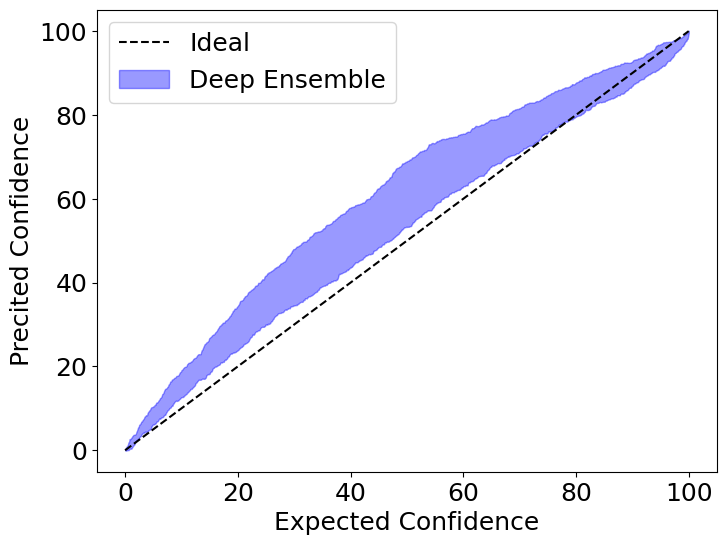

In [34]:
fig = plt.figure(figsize=(8,6))
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.fill_between(alphas,
                np.mean(allCI_DE, axis = 1)+np.std(allCI_DE, axis = 1),
                np.mean(allCI_DE, axis = 1)-np.std(allCI_DE, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Deep Ensemble')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

## UQ Model: MC Dropout

Simple MLP architecture with 10% dropout probability

In [35]:
def generate_trained_MCmodel(trainX, trainY, nepochs, actfn = 'sigmoid'):

    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    x = Dropout(rate = 0.10)(x)
    x = Dense(10, activation = actfn)(x)
    x = Dropout(rate = 0.10)(x)
    mu = Dense(1, activation = actfn)(x)

    model = Model(feature_input, mu)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)

    return model

In [36]:
nmodels = 5
all_models_MC=[]
all_mae_train_MC = np.zeros(nmodels,)
pbar = ProgressBar()
for i in pbar(range(nmodels)):
    model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, 3000, 'sigmoid')
    all_mae_train_MC[i] = mae(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
    all_models_MC.append(model_MC)

2022-12-12 11:32:39.932558: W tensorflow/c/c_api.cc:291] Operation '{name:'training_220/Adam/dense_221/kernel/v/Assign' id:52430 op device:{requested: '', assigned: ''} def:{{{node training_220/Adam/dense_221/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_220/Adam/dense_221/kernel/v, training_220/Adam/dense_221/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:33:11.433934: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_224/kernel/Assign' id:52593 op device:{requested: '', assigned: ''} def:{{{node dense_224/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_224/kernel, dense_224/kernel/Initializer/stateless_random_uniform)}}' was changed

In [37]:
select_modelMC = all_models_MC[np.argmin(all_mae_train_MC)]
print("Train MAE: ", mae(K.get_value(select_modelMC(Xtrain_norm))*(np.max(Ytrain)), Ytrain))
print("Test1 MAE: ", mae(K.get_value(select_modelMC(Xtest1_norm))*(np.max(Ytrain)), Ytest1))
print("Test2 MAE: ", mae(K.get_value(select_modelMC(Xtest2_norm))*(np.max(Ytrain)), Ytest2))
print("Test3 MAE: ", mae(K.get_value(select_modelMC(Xtest3_norm))*(np.max(Ytrain)), Ytest3))

Train MAE:  30.021028844321645
Test1 MAE:  99.2736082531157
Test2 MAE:  300.38973846435545
Test3 MAE:  237.09118381076388


In [38]:
allresults_MCdf = pd.DataFrame()
for myset in dataset:
    exec("Xnorm =X"+myset+"_norm")
    exec("Y =Y"+myset)

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    for i in range(nmodels_select):
        result_df["MC_mu_"+str(i)] = K.get_value(select_modelMC(Xnorm, training=True))*(np.max(Ytrain))

    allresults_MCdf = pd.concat([allresults_MCdf, result_df], axis = 0)
allresults_MCdf = get_ensemble(allresults_MCdf, "MC", nmodels_select)

/tmp/ipykernel_1688229/625823574.py:5: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  intervals = scipy.stats.norm.interval(alpha=myalpha, loc=mu, scale=sigma)


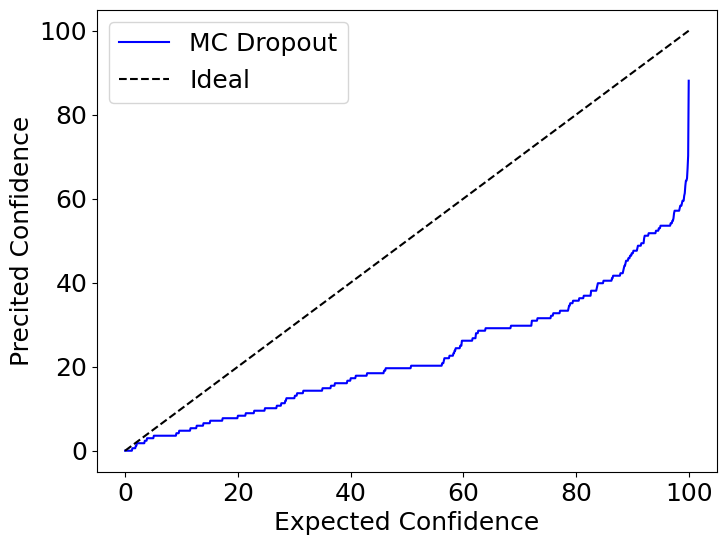

In [39]:
alphas, CI_DE = get_confidence_interval(allresults_MCdf['True'].values, 
                                       allresults_MCdf['MC_mu_eff'].values, 
                                       allresults_MCdf['MC_sigma_eff'].values)
fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_DE, color = 'blue', label='MC Dropout')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

In [ ]:
## Repeat 10 times
nmodels = 5 # total models trained and best one picked
nmodels_select = 5 # run 5 times per each select model with dropout
niter = 10

allCI_MC = np.zeros((1000, niter))
pbar=ProgressBar()

for myiter in pbar(range(niter)):
    all_models_MC=[]
    all_mae_train_MC = np.zeros(nmodels,)
    pbar = ProgressBar()
    for i in range(nmodels):
        model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, 3000, 'sigmoid')
        all_mae_train_MC[i] = mae(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
        all_models_MC.append(model_MC)

    select_modelMC = all_models_MC[np.argmin(all_mae_train_MC)]

    allresults_MCdf = pd.DataFrame()
    for myset in dataset:
        exec("Xnorm =X"+myset+"_norm")
        exec("Y =Y"+myset)

        result_df = pd.DataFrame(Y, columns = ['True'])
        result_df['dataset'] = myset
        for i in range(nmodels_select):
            result_df["MC_mu_"+str(i)] = K.get_value(select_modelMC(Xnorm, training=True))*(np.max(Ytrain))

        allresults_MCdf = pd.concat([allresults_MCdf, result_df], axis = 0)
    allresults_MCdf = get_ensemble(allresults_MCdf, "MC", nmodels_select)

    alphas, CI_MC = get_confidence_interval(allresults_MCdf['True'].values, 
                                           allresults_MCdf['MC_mu_eff'].values, 
                                           allresults_MCdf['MC_sigma_eff'].values)
    allCI_MC[:,myiter] = CI_MC

2022-12-12 11:36:08.476070: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_236/bias/Assign' id:55010 op device:{requested: '', assigned: ''} def:{{{node dense_236/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_236/bias, dense_236/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:36:41.300870: W tensorflow/c/c_api.cc:291] Operation '{name:'training_232/Adam/dense_238/kernel/m/Assign' id:55602 op device:{requested: '', assigned: ''} def:{{{node training_232/Adam/dense_238/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_232/Adam/dense_238/kernel/m, training_232/Adam/dense_238/kernel/m/Initializer/zeros)}}' was changed by setting attribute after

2022-12-12 11:45:05.906535: W tensorflow/c/c_api.cc:291] Operation '{name:'training_256/Adam/dense_274/bias/m/Assign' id:61763 op device:{requested: '', assigned: ''} def:{{{node training_256/Adam/dense_274/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_256/Adam/dense_274/bias/m, training_256/Adam/dense_274/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-12-12 11:45:41.709111: W tensorflow/c/c_api.cc:291] Operation '{name:'training_258/Adam/beta_1/Assign' id:62139 op device:{requested: '', assigned: ''} def:{{{node training_258/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_258/Adam/beta_1, training_258/Adam/beta_1/Initializer/initial_value)}}

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.fill_between(alphas,
                np.mean(allCI_MC, axis = 1)+np.std(allCI_MC, axis = 1),
                np.mean(allCI_MC, axis = 1)-np.std(allCI_MC, axis = 1),
                color='red', alpha = 0.4, linestyle='None', label='MC-Dropout')
plt.fill_between(alphas,
                np.mean(allCI_DE, axis = 1)+np.std(allCI_DE, axis = 1),
                np.mean(allCI_DE, axis = 1)-np.std(allCI_DE, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Deep Ensemble')

plt.xlabel('Expected Confidence')
plt.ylabel('Observed Confidence')
plt.legend()